In [1]:
import numpy as np
import pandas as pd 
import glob 
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from Math_From_Scratch import regression

In [2]:
datasets_path = glob.glob(r'..\data\*.csv')

csv_files = {
    path.split("\\")[-1][:-4]: path
    for path in datasets_path
}

WINDOW_SIZE = 5

df = pd.read_csv(csv_files['dehliclimate'])
df['date'] = pd.to_datetime(df['date'])

features = df.drop(columns=['meantemp','date']).columns
all_metrics = df.drop(columns=['date']).columns

df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.day_of_week
df['year'] = df['date'].dt.year


target = ["meantemp"]

### Simple Moving Average (SMA):
$ SMA_t = \frac{1}{N} \sum_{i=t-N+1}^{t} y_i $

𝑦𝑖 = is the value of the time series at time 
𝑁 = is the window size (number of periods).

𝑡 = is the current time period.

The summation ∑ runs from 𝑡−𝑁+1
t−N+1 to 𝑡, meaning the sum is over the past 𝑁 periods.

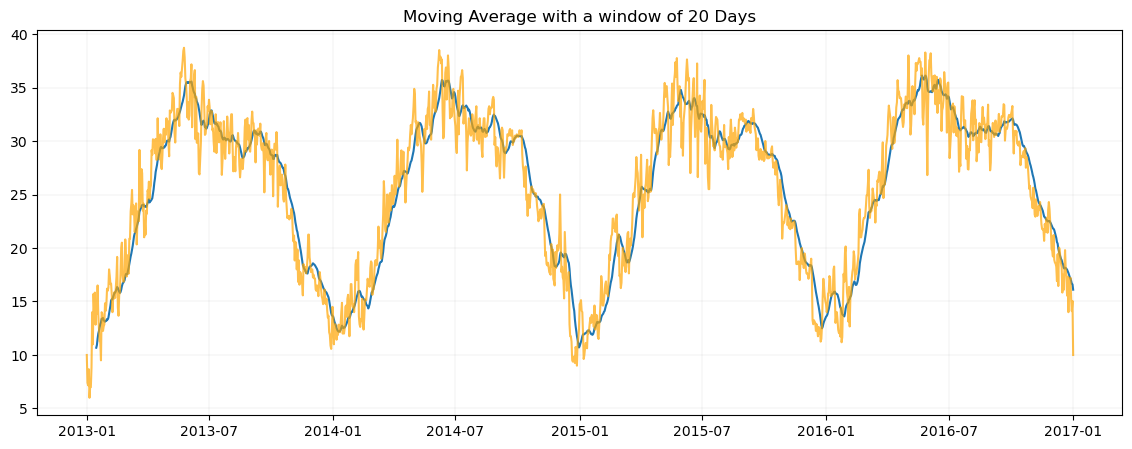

In [3]:
regression.SMA(df, 'meantemp' , 15,'mean')


fig = plt.figure(figsize=(14,5))
plt.title("Moving Average with a window of 20 Days")
plt.plot(df['date'], df['meantemp_15_mean'], linestyle='-')
plt.plot(df['date'], df[target], alpha=0.7,color='orange')
plt.grid(True, color='gray', linestyle='-', linewidth=0.08)

### Exponential Moving Average: 
$ EMA_t = \alpha y_t + (1 - \alpha) EMA_{t-1} $

$y_t$ is the actual value at time $t$.

Smoothing Factor: $\alpha = \frac{2}{N + 1}$

In [4]:
def exp_moving_average(df: pd.DataFrame, column: str ,n_window:int) -> pd.DataFrame|ValueError:

    smoothing_factor = (2/(n_window + 1))

    if n_window == 0 or n_window > len(df):
        print("INVALID WINDOW RANGE")
        return ValueError
    else:

        metric_name = column
        col_name = f'ema_{metric_name}_{n_window}'
        
        df[col_name] = np.nan


        for n in range(len(df)):

            if n == 0:
                df.loc[n, col_name] = df.loc[n, column]

            else:
                last_ema = df.loc[n-1, col_name]
                actual_y = df.loc[n, column]

                df.loc[n, col_name] = actual_y * smoothing_factor + (1 - smoothing_factor) * last_ema



        return df

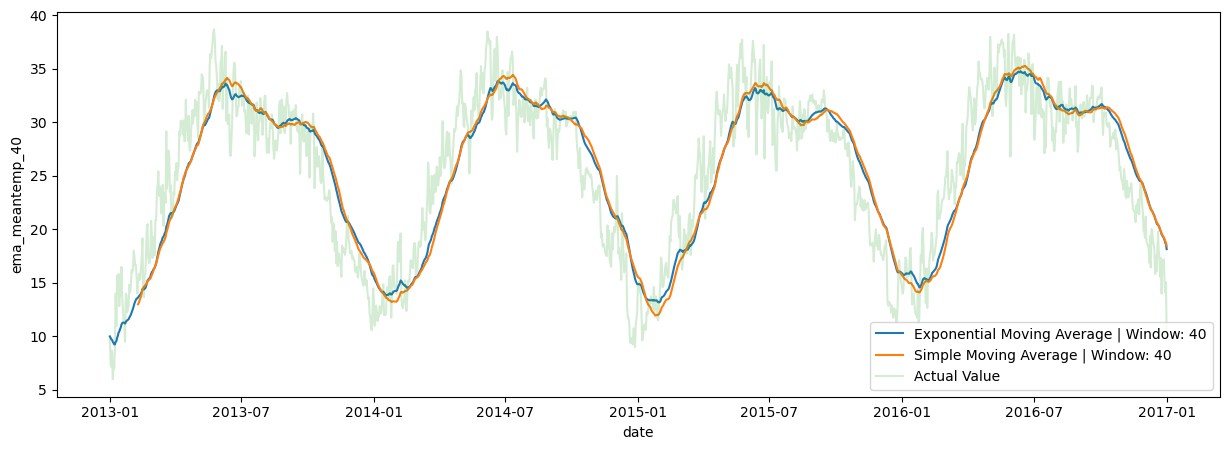

In [5]:
WINDOW_SIZE = 40

df_plt = regression.SMA(df=df, column='meantemp' , n_window=WINDOW_SIZE)
df_plt = exp_moving_average(df=df , column='meantemp', n_window=WINDOW_SIZE)

fig = plt.figure(figsize=(15,5))
sns.lineplot(df_plt, x='date', y=f'ema_meantemp_{WINDOW_SIZE}', label=f"Exponential Moving Average | Window: {WINDOW_SIZE}")
sns.lineplot(df_plt, x='date', y=f'meantemp_{WINDOW_SIZE}_mean',alpha=1.0 , label=f"Simple Moving Average | Window: {WINDOW_SIZE}")
sns.lineplot(df_plt, x='date', y='meantemp',alpha=0.2, label="Actual Value")
plt.legend()
plt.show()

## **Stationary and NoN-Stationary Data: AR | MA | ARMA | ARIMA**
* **AR:** Depends *only* on lagged values of the time series ($y_t$).
* **MA:** Depends *only* on lagged values of the error terms ($\varepsilon_t$).
* **ARMA:** Depends on *both* lagged values of the time series ($y_t$) and lagged values of the error terms ($\varepsilon_t$).

### AR(p) – Autoregressive model of order p

Uses only past values of the series itself:
$y_t = c + \sum_{i=1}^p \phi_i\,y_{t-i} + \varepsilon_t$
No lagged-error terms appear here—just the autoregressive part.

- $X_t$ : the value of the time series at time $t$  
- $c$ : constant term (intercept)  
- $\phi_i$: autoregressive coefficients (weights)  
- $X_{t-i}$: the value at lag $i$  
- $\epsilon_t$: error term (white noise) 
- $p$: number of lags (order of the model)

In [36]:
def ar_linear_regression(y:pd.Series, n_window: int) -> tuple[float,float]:
    # Returns the AR (coef,intercept)
    y_lagged = y.shift(n_window)
    df = pd.DataFrame({'y': y})

    df['y_lag'] = y_lagged

    df = df.dropna()

    coef = regression.coefficient(df['y_lag'], df['y'])
    intercept = regression.intercept(df['y_lag'], df['y'], coef)

    return [coef,intercept]


In [138]:
def AR(X, y:pd.DataFrame, n_window:int):
    
    y = y.copy()

    y_pred = regression.multiple_regression(X,y, return_params=False) 
    
    y[f'ar_pred_lag{n_window}'] = np.nan
    y['pred'] = y_pred
    y['pred_error'] = y.iloc[:,0] - y['pred']

    ar_params= ar_linear_regression(y.iloc[:,0] , n_window)
    coef = ar_params[0]
    intercept = ar_params[1]


    for actual_idx in range(len(y)):
        sum_iter_lags = np.array([])

        if actual_idx >= n_window:
            for idx in range(1,n_window + 1):
                lag_iter_val = (y.iloc[actual_idx-idx,0] * coef) #+ y['pred_error'].loc[actual_idx]
                #print(lag_iter_val)
                sum_iter_lags = np.append(sum_iter_lags, lag_iter_val)

            #print("\n-------",intercept + sum_iter_lags.sum(), sum_iter_lags.sum())
            y.loc[actual_idx, f'ar_pred_lag{n_window}'] = intercept + sum_iter_lags.sum()
    return y

### MA(q) – Moving-Average Model of Order q

The Moving-Average (MA) model of order $q$, denoted as MA($q$), is a time series model that posits that the current value of a variable, $y_t$, is a linear combination of the current and past $q$ white noise error terms (shocks).

**Key Characteristics:**

* **Dependence on Past Errors:** Unlike Autoregressive (AR) models that depend on past values of the time series itself, MA models depend solely on the past error terms. These error terms represent the unpredictable or random component of the time series at each point in time.
* **No Direct Dependence on Past Values of $y$:** The model does not include any lagged values of the observed variable $y$. The influence of the past is channeled entirely through the accumulated effect of past random shocks.
* **White Noise Errors:** The error terms, $\varepsilon_t, \varepsilon_{t-1}, \varepsilon_{t-2}, ..., \varepsilon_{t-q}$, are assumed to be independently and identically distributed (i.i.d.) with a mean of zero and a constant variance, $\sigma^2$. They represent random, unpredictable disturbances.

**Mathematical Formulation:**

The MA($q$) model is mathematically expressed as:

$$y_t = c + \varepsilon_t + \theta_1\varepsilon_{t-1} + \theta_2\varepsilon_{t-2} + \cdots + \theta_q\varepsilon_{t-q}$$

Which can be compactly written using summation notation as:

$$y_t = c + \varepsilon_t + \sum_{j=1}^q \theta_j\,\varepsilon_{t-j}$$

Where:

* $y_t$ is the value of the time series at time $t$.
* $c$ is a constant term (the mean of the process if the error terms have a mean of zero).
* $\varepsilon_t$ is the white noise error term at time $t$.
* $\theta_1, \theta_2, ..., \theta_q$ are the parameters of the model, representing the weights or coefficients associated with the past error terms. These parameters determine the extent to which past shocks influence the current value of the series.
* $q$ is the order of the moving average model, indicating how many past error terms are included in the model.

**Summary:**

The MA($q$) model provides a way to model time series where the current observation is a function of the current and a finite number of past unobserved random shocks. It focuses on the propagation of these random disturbances through time to explain the behavior of the series, without directly considering the past values of the series itself.

In [137]:
def MA(X, y:pd.DataFrame, n_window:int):
    
    y = y.copy()

    y_pred = regression.multiple_regression(X,y, return_params=False) 

    y['pred'] = y_pred
    y['pred_error'] = y.iloc[:,0] - y['pred']

    ar_params= ar_linear_regression(y.iloc[:,0] , n_window)
    coef = ar_params[0]
    intercept = ar_params[1]


    for actual_idx in range(len(y)):
        sum_iter_lags = np.array([])

        if actual_idx >= n_window:
            for idx in range(1,n_window + 1):
                lag_iter_val = y['pred_error'].loc[actual_idx - idx] * coef 
                sum_iter_lags = np.append(sum_iter_lags, lag_iter_val)

            y.loc[actual_idx, f'ma_pred_lag{n_window}'] = intercept + sum_iter_lags.sum()
    return y

In [254]:
MA(df[features],df[target],2).tail(2)

,meantemp,pred,pred_error,ma_pred_lag2
1460,15.052632,19.464656,-4.412024,-6.837335
1461,10.000000,15.174500,-5.174500,-7.424168


### ARMA(p, q) – Autoregressive Moving Average Model of Order (p, q)

The Autoregressive Moving Average (ARMA) model of order $(p, q)$, denoted as ARMA($p, q$), combines the characteristics of both Autoregressive (AR) and Moving Average (MA) models. It posits that the current value of a time series, $y_t$, is a linear function of its own past values and the current and past white noise error terms.

**Mathematical Formulation:**

The ARMA($p, q$) model is mathematically expressed as:

$$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \cdots + \theta_q \varepsilon_{t-q}$$

Which can be compactly written using summation notation as:

$$y_t = c + \sum_{i=1}^p \phi_i\,y_{t-i} + \varepsilon_t + \sum_{j=1}^q \theta_j\,\varepsilon_{t-j}$$

Where:

* $y_t$ is the value of the time series at time $t$.
* $c$ is a constant term.
* $\phi_1, \phi_2, ..., \phi_p$ are the autoregressive parameters, indicating the influence of past $y$ values on the current value.
* $p$ is the order of the autoregressive part.
* $\varepsilon_t$ is the white noise error term at time $t$.
* $\theta_1, \theta_2, ..., \theta_q$ are the moving average parameters, indicating the influence of past error terms on the current value.
* $q$ is the order of the moving average part.

**Summary:**

The ARMA($p, q$) model provides a flexible framework for modeling time series that exhibit a blend of autoregressive and moving average behavior. By incorporating both past values of the series and past random shocks, it can capture more complex dependencies and provide a richer understanding of the underlying dynamics of the time series. Choosing the appropriate orders $p$ and $q$ is crucial for effectively modeling a given time series.

In [216]:
def ARMA(X, y:pd.DataFrame, n_window:int):
    
    y = y.copy()

    y_pred = regression.multiple_regression(X,y, return_params=False) 
    
    y['pred'] = y_pred
    y['pred_error'] = y.iloc[:,0] - y['pred']

    ar_coefs, ar_intercept = ar_linear_regression(y.iloc[:,0], n_window)
    ma_coefs, _ = ar_linear_regression(y['pred_error'], n_window)


    for actual_idx in range(len(y)):
        sum_iter_lags = np.array([])
        sum_err_iter_lags  = np.array([])
        if actual_idx >= n_window:
            for idx in range(1,n_window + 1):
                lag_err_iter_val = y['pred_error'].loc[actual_idx - idx] * ar_coefs 
                lag_iter_val = y.iloc[actual_idx-idx,0] * ma_coefs

                sum_iter_lags = np.append(sum_iter_lags, lag_iter_val)
                sum_err_iter_lags = np.append(sum_err_iter_lags, lag_err_iter_val)


            y.loc[actual_idx, f'arma_pred_lag{n_window}'] = ar_intercept + sum_iter_lags.sum() + sum_err_iter_lags.sum()
    return y

In [230]:

y_ar = AR(df[features],df[target],1).dropna()
y_ma = MA(df[features],df[target],2).dropna()
y_arma = ARMA(df[features],df[target],1).dropna()

In [252]:
ARMA(df[features],df[target],3).dropna()

,meantemp,pred,pred_error,arma_pred_lag3
3,8.666667,22.066868,-13.400201,-5.915000
4,6.000000,18.879302,-12.879302,-11.416124
5,7.000000,19.435333,-12.435333,-15.206044
6,7.000000,21.240597,-14.240597,-15.919624
7,8.857143,24.857166,-16.000023,-18.166198
...,...,...,...,...
1457,17.217391,23.234196,-6.016805,27.697602
1458,15.238095,19.035750,-3.797655,28.677776
1459,14.095238,18.658390,-4.563152,28.521297
1460,15.052632,19.464656,-4.412024,28.705813


In [243]:
arma_rmse = np.round(regression.RMSE(y_arma['meantemp'].values,y_arma['arma_pred_lag1'].values),2)
ar_rmse = np.round(regression.RMSE(y_ar['meantemp'].values, y_ar['ar_pred_lag1'].values),2)
reg_rmse =  np.round(regression.RMSE(y_ar['meantemp'].values,y_ar['pred'].values),2)

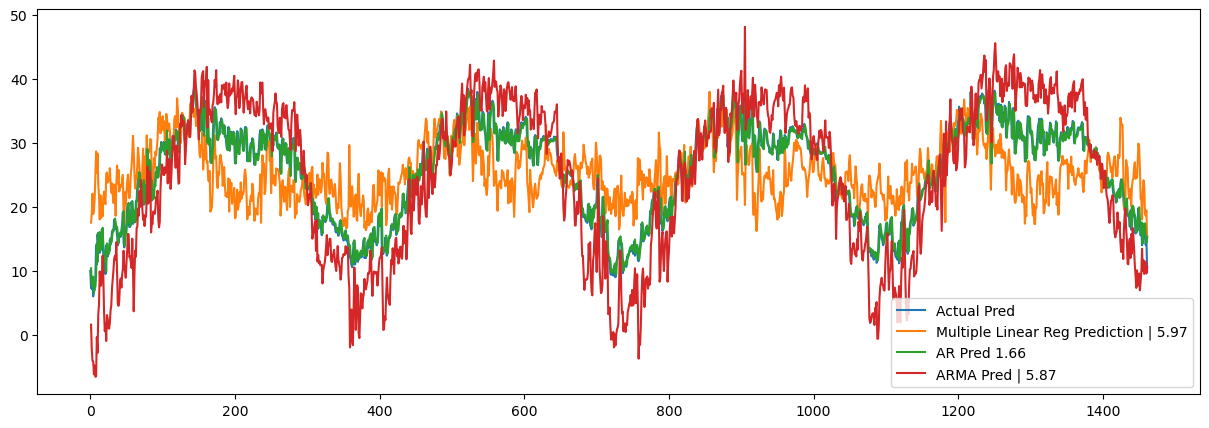

In [250]:
fig = plt.figure(figsize=(15,5))
plt.plot(df[target]['meantemp'],label='Actual Pred')
plt.plot(y_ar['pred'],label=f'Multiple Linear Reg Prediction | {reg_rmse}')
plt.plot(y_ar['ar_pred_lag1'],label=f'AR Pred {ar_rmse}')
plt.plot(y_arma['arma_pred_lag1'],label=f'ARMA Pred | {arma_rmse}')
plt.legend()
plt.show()

In [ ]:
def SMA(df: pd.DataFrame, column: str ,n_window:int, method:str = 'mean') -> pd.DataFrame|None:
    # Simple Moving Average
    methods = ['mean','sum','std','median']


    if n_window == 0 or n_window > len(df):
        print("INVALID WINDOW RANGE")
    elif method not in methods:
        print(f"Invalid operation {method} \nAvailable Methods:{methods}")
    else:
        metric_name = column
        col_name = f'{metric_name}_{n_window}_{method}'
        df[col_name] = np.nan

        for n in range(len(df)):

            if n >= n_window-1 and n != 0:
                window_values = np.array([],dtype=float)

                for idx in range(n_window):
                    iter_val = df[column][np.abs(n-idx)]
                    window_values = np.append(window_values, iter_val)

In [ ]:
AR(df[features],df[target],2)

,meantemp,pred,pred_error,rolling_pred_2
0,10.000000,18.787868,-8.787868,NaN
1,7.400000,17.549253,-10.149253,NaN
2,7.166667,18.997866,-11.831199,[-21066.05627023595]
3,8.666667,22.066868,-13.400201,[-21066.05627023595]
4,6.000000,18.879302,-12.879302,[-21066.05627023595]
...,...,...,...,...
1457,17.217391,23.234196,-6.016805,[-21066.05627023595]
1458,15.238095,19.035750,-3.797655,[-21066.05627023595]
1459,14.095238,18.658390,-4.563152,[-21066.05627023595]
1460,15.052632,19.464656,-4.412024,[-21066.05627023595]


In [ ]:
for col in enumerate(df[features].columns):
    print(col[0])

0
1
2


In [ ]:
y_pred, intercept, coef = regression.multiple_regression(df[features],df[target], return_params=True)
y = df[target].copy()
y['pred'] = y_pred
y['pred_error'] = y.iloc[:,0] - y['pred']
y

,meantemp,pred,pred_error
0,10.000000,18.787868,-8.787868
1,7.400000,17.549253,-10.149253
2,7.166667,18.997866,-11.831199
3,8.666667,22.066868,-13.400201
4,6.000000,18.879302,-12.879302
...,...,...,...
1457,17.217391,23.234196,-6.016805
1458,15.238095,19.035750,-3.797655
1459,14.095238,18.658390,-4.563152
1460,15.052632,19.464656,-4.412024


In [ ]:
df_month_mean = df.groupby(by=['month'])[all_metrics].mean().reset_index()
df_month_mean.style.background_gradient().set_properties(**{'font-size': '15px', 'text-align': 'center'}) 

,month,meantemp,humidity,wind_speed,meanpressure
0,1,13.311914,78.603500,4.945358,1018.152410
1,2,17.620422,67.959397,6.531042,1015.349232
2,3,22.914103,60.698463,7.696836,1066.531388
3,4,29.376614,39.036537,8.783093,1006.975741
4,5,33.315889,35.739941,9.022982,1001.975698
5,6,33.734011,50.628724,9.381606,997.878522
6,7,30.995782,70.631436,7.418752,998.040354
7,8,30.601777,70.469849,6.923782,984.358104
8,9,30.433216,60.724564,7.596360,1007.465067
9,10,27.113154,61.220659,4.761333,1010.509337
